<a href="https://colab.research.google.com/github/pratibhavhegde/pratibhavhegde/blob/main/PVH_YOLOV12_DroneData_Eval_OD_17Jul2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Jul 21 04:33:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 83.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-07-21 04:35:34--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-07-21 04:35:34 (141 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 99.8MB/s]


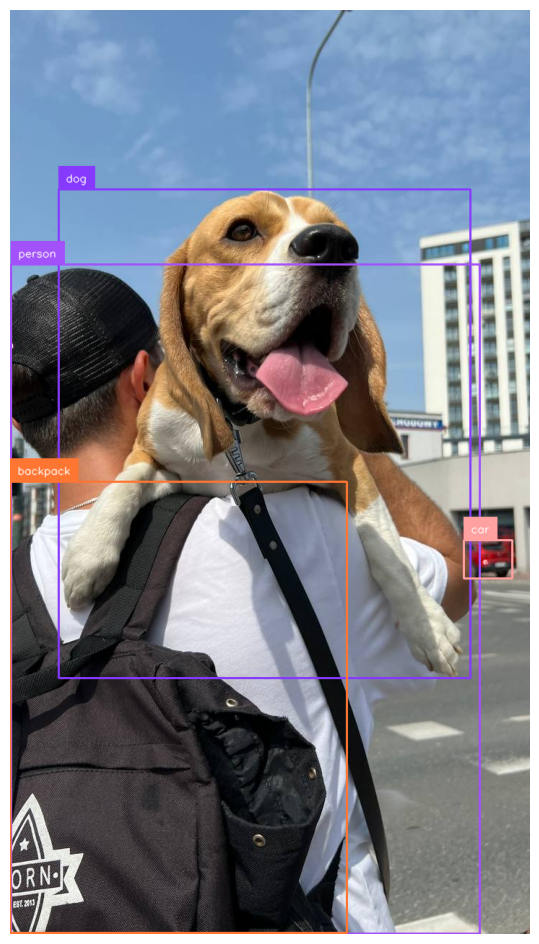

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/odaerialdata/od_drone-gzfm1/dataset/9', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to OD_Drone-9 in yolov8:: 100%|██████████| 21812/21812 [00:03<00:00, 6968.70it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

names:
- AirPlane
- Aircraft
- Animals
- Autorickshaw
- Ball
- Bicycle
- Bird
- Bridge
- Building
- Bus
- Car
- Clouds
- Drone
- ElectricPole
- Goalkeeper
- Hedges
- Helicopter
- Hotairballoon
- House
- Landscape
- Motorbike
- Mountain
- Nest
- Parachute
- Paraglider
- Person
- Pilot
- Plants and Bushes
- Player
- Referee
- Road
- Sea
- Sky
- Skyscrapper
- Street Light
- Tempo
- Traffic Light
- Train_Track
- Transformer
- Trees
- Truck
- Van
- Vegetation
- Wire
- objects
nc: 45
roboflow:
  license: Public Domain
  project: od_drone-gzfm1
  url: https://universe.roboflow.com/odaerialdata/od_drone-gzfm1/dataset/9
  version: 9
test: /content/OD_Drone-9/test/images
train: /content/OD_Drone-9/train/images
val: /content/OD_Drone-9/valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.168 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/OD_Drone-9/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=45

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 97.0MB/s]


AMP: checks passed ✅


train: Scanning /content/OD_Drone-9/train/labels... 9177 images, 79 backgrounds, 0 corrupt: 100%|██████████| 9177/9177 [00:05<00:00, 1555.79it/s]


train: New cache created: /content/OD_Drone-9/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 92, len(boxes) = 31038. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/OD_Drone-9/valid/labels... 1061 images, 15 backgrounds, 0 corrupt: 100%|██████████| 1061/1061 [00:00<00:00, 1249.01it/s]

val: New cache created: /content/OD_Drone-9/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 76, len(boxes) = 4183. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.26G      3.415      5.517       4.28         31        640: 100%|██████████| 574/574 [03:43<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


                   all       1061       4183    0.00187     0.0265    0.00115   0.000279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.1G      3.263      5.318       4.02         86        640: 100%|██████████| 574/574 [03:37<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


                   all       1061       4183      0.221     0.0125    0.00206   0.000447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.85G      2.595      4.263      2.887         60        640: 100%|██████████| 574/574 [03:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.11it/s]


                   all       1061       4183      0.583     0.0349     0.0479     0.0189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.82G      1.972      3.269      2.123         89        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


                   all       1061       4183      0.412      0.113      0.105     0.0494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.87G      1.717      2.822      1.852         31        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


                   all       1061       4183      0.387      0.154       0.14     0.0707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.41G      1.602      2.578      1.727         68        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]


                   all       1061       4183      0.342      0.187      0.144     0.0747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.13G      1.503      2.361      1.641         80        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]

                   all       1061       4183      0.396      0.188       0.18     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.48G      1.442      2.246      1.587         24        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.22it/s]

                   all       1061       4183      0.311      0.218      0.197       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.45G      1.381      2.128       1.54         50        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]

                   all       1061       4183      0.427      0.216      0.207      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         7G      1.342      2.044      1.505         57        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.20it/s]


                   all       1061       4183      0.345      0.248      0.235      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.57G      1.307      1.978      1.475         37        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.21it/s]

                   all       1061       4183      0.398      0.241      0.239      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.59G      1.288      1.905      1.452         51        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.26it/s]

                   all       1061       4183      0.477      0.237      0.238      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.45G      1.262      1.846      1.436         61        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]

                   all       1061       4183      0.366      0.252      0.234      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       7.8G      1.229      1.786      1.413         38        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.494      0.257      0.265      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.55G      1.204      1.746       1.39         38        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.22it/s]

                   all       1061       4183      0.397      0.278      0.268       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.63G      1.199      1.711      1.382         42        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.20it/s]

                   all       1061       4183       0.52      0.252      0.264      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.69G      1.167      1.678      1.362         34        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

                   all       1061       4183       0.38      0.293      0.281       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.17G      1.153      1.639      1.352         29        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]

                   all       1061       4183      0.384      0.292      0.281      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.98G      1.132      1.586      1.338         85        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.397      0.279      0.288      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.83G      1.137      1.597       1.34         57        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

                   all       1061       4183      0.389      0.295      0.286      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.16G      1.109       1.55       1.32         52        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.416      0.291      0.296      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.98G        1.1      1.519      1.314        129        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183       0.39      0.285      0.298      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.44G      1.081      1.496      1.307         32        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.383      0.305      0.285      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       7.4G      1.083      1.466      1.296         72        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.428      0.313      0.309      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.53G      1.066      1.441      1.287        122        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.495      0.294      0.306      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.57G      1.072      1.446      1.291         45        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.23it/s]

                   all       1061       4183      0.461      0.314      0.314      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.04G      1.045      1.414      1.277        164        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183       0.44      0.313      0.318      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.68G      1.041      1.385       1.27        114        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]

                   all       1061       4183       0.45      0.327      0.316      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.45G      1.024       1.37      1.265         32        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.453      0.332      0.322      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.23G       1.04      1.357      1.262         30        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.498      0.342      0.318      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.36G      1.016      1.326      1.251         75        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

                   all       1061       4183      0.486      0.331      0.324      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.08G      1.009      1.321      1.249         78        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.518      0.347      0.335      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.79G      1.001      1.301      1.241         63        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]

                   all       1061       4183      0.437      0.345      0.329      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.07G     0.9888      1.289      1.236         68        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.472      0.343      0.335      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.58G      0.991      1.265      1.229         45        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.26it/s]

                   all       1061       4183      0.441      0.337      0.345      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       8.5G     0.9803      1.257      1.228         23        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.423      0.337      0.329       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.57G     0.9722      1.246      1.221         41        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.482      0.358      0.359      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.19G     0.9614      1.236      1.219         53        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.524      0.355      0.352      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.83G     0.9487      1.206      1.209         80        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]

                   all       1061       4183      0.508      0.367      0.344      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.43G     0.9481      1.204       1.21         39        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.478      0.354      0.342      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.31G     0.9417      1.179      1.205         42        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.494      0.354      0.355      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.52G     0.9485      1.179      1.206         37        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.517      0.345      0.346      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.49G     0.9258      1.162      1.201         52        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183       0.53      0.349       0.36       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.82G     0.9356      1.166      1.198         53        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.531      0.349      0.358      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.99G     0.9289      1.138      1.193         55        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.501      0.379      0.362      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.63G     0.9272      1.131      1.191         82        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]

                   all       1061       4183      0.469      0.394      0.363      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.35G     0.9217      1.124      1.188         41        640: 100%|██████████| 574/574 [03:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.25it/s]

                   all       1061       4183      0.533      0.376      0.367      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.44G     0.9053      1.112      1.179         55        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.535      0.374      0.369      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.98G     0.8995      1.102      1.181         72        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.493      0.387      0.363      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.95G     0.8992       1.09      1.177         79        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.492      0.374      0.368      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.12G     0.8968      1.083      1.177         66        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.509      0.393      0.372      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.66G     0.8941      1.068      1.173         76        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.25it/s]

                   all       1061       4183      0.449      0.393      0.366      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.55G     0.8808      1.048       1.16         46        640: 100%|██████████| 574/574 [03:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.448      0.378       0.37      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.99G     0.8869      1.058      1.167         85        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.454      0.372      0.375      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.13G     0.8833       1.04      1.161         48        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.486      0.402      0.379      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.84G     0.8737      1.031      1.159         70        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.26it/s]

                   all       1061       4183      0.551      0.355      0.375      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.84G     0.8694      1.014      1.154         54        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.537      0.376      0.379      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.88G     0.8564      1.007      1.152         51        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.535      0.388      0.389      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.26G      0.859     0.9963       1.15         37        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.563       0.38      0.381      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.48G     0.8587     0.9883      1.147         40        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.456      0.403      0.384      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.79G     0.8623     0.9916      1.146         59        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.459      0.418      0.386      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.95G     0.8403     0.9637      1.133         59        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.491      0.377      0.384       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.61G     0.8401     0.9585      1.135         42        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.474      0.383      0.386      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.28G     0.8299     0.9408      1.134         85        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.471      0.404      0.385       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.16G     0.8254     0.9483      1.127         34        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.482      0.396      0.386      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       7.2G     0.8311     0.9312      1.128         47        640: 100%|██████████| 574/574 [03:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.452      0.393      0.387      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.88G     0.8223     0.9293      1.127         48        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.482      0.382      0.388      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.63G     0.8295     0.9202      1.128         45        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.469      0.395      0.392      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.36G     0.8278     0.9205      1.125         26        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.469      0.407      0.391      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.46G     0.8141     0.9166      1.124        140        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]

                   all       1061       4183      0.487      0.386      0.388      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.89G     0.8125     0.9024      1.119         47        640: 100%|██████████| 574/574 [03:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183       0.51      0.381      0.389      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.94G     0.8071     0.8991      1.115         40        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183       0.49      0.386      0.387      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.22G     0.8022     0.8859      1.115         38        640: 100%|██████████| 574/574 [03:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183       0.48       0.39      0.388      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.37G     0.7952     0.8738      1.109         24        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.465      0.402      0.388      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.44G     0.7927      0.865      1.108        103        640: 100%|██████████| 574/574 [03:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]

                   all       1061       4183      0.468      0.403      0.388      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.56G     0.7909     0.8661      1.111         78        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.488      0.391      0.385      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       7.3G      0.788     0.8537      1.104         44        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.495      0.389       0.39      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.89G     0.7695     0.8416      1.094         51        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.491      0.393      0.388      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       7.6G     0.7726     0.8385      1.099         24        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.34it/s]

                   all       1061       4183      0.491      0.395      0.386      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.28G     0.7658     0.8311      1.094         47        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]

                   all       1061       4183      0.501      0.385      0.388      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.08G     0.7615     0.8169      1.094         50        640: 100%|██████████| 574/574 [03:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.487      0.386      0.386      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.51G     0.7534     0.8115      1.087         85        640: 100%|██████████| 574/574 [03:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]

                   all       1061       4183      0.463      0.399      0.384      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.32G     0.7575     0.8024      1.084         64        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183       0.47      0.396      0.384      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.17G     0.7664     0.7989      1.087         36        640: 100%|██████████| 574/574 [03:34<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.33it/s]

                   all       1061       4183      0.481      0.395      0.386      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.27G     0.7429     0.7886      1.083         65        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.33it/s]

                   all       1061       4183      0.478      0.394      0.387      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.94G     0.7457     0.7795      1.078         52        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.479      0.391      0.387      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.24G     0.7472     0.7835      1.084         61        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]

                   all       1061       4183      0.482      0.389      0.388      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.35G     0.7333     0.7737      1.078         64        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183       0.48      0.393       0.39      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.23G     0.7331     0.7687      1.075         41        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.486      0.392      0.391      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       8.1G     0.7317     0.7617      1.074         30        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.26it/s]

                   all       1061       4183      0.474      0.398      0.392      0.258


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.02G     0.7102     0.6184      1.047         16        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.477      0.389      0.391      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.19G     0.6938     0.5777       1.04         17        640: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.481       0.39      0.391      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       8.1G     0.6797     0.5632      1.029         10        640: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.33it/s]

                   all       1061       4183      0.484      0.393      0.392      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.52G     0.6758     0.5496      1.029         33        640: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]

                   all       1061       4183      0.485      0.397      0.393       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.08G     0.6702       0.54      1.021         44        640: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]

                   all       1061       4183      0.497      0.388      0.395      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.87G     0.6675     0.5356      1.021         13        640: 100%|██████████| 574/574 [03:33<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all       1061       4183      0.491      0.388      0.395      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       7.8G     0.6517     0.5288      1.012         10        640: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.489      0.389      0.396      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.21G     0.6471     0.5143      1.005         28        640: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]

                   all       1061       4183      0.505      0.387      0.397      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       7.3G     0.6494      0.514       1.01         14        640: 100%|██████████| 574/574 [03:33<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.33it/s]

                   all       1061       4183      0.508       0.39      0.397       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.46G     0.6408     0.5074      1.004         50        640: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]

                   all       1061       4183      0.504      0.389      0.397       0.26



100 epochs completed in 6.215 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12s summary (fused): 376 layers, 9,091,623 parameters, 0 gradients, 19.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.05it/s]


                   all       1061       4183      0.496      0.387      0.396      0.261
              AirPlane         23         36      0.444      0.194      0.238      0.131
              Aircraft        218        268      0.739      0.847      0.795       0.59
                  Ball         39         39      0.679     0.0551       0.12     0.0322
               Bicycle          1          2          0          0    0.00176   0.000882
                  Bird         49         73      0.489      0.551      0.484       0.26
                Bridge         56         57       0.87       0.93      0.945      0.644
              Building         23        331          0          0          0          0
                   Car          6         19     0.0154     0.0526    0.00791    0.00267
                Clouds          1          2          0          0          0          0
                 Drone        130        246      0.848      0.818      0.897      0.567
          ElectricPol

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2.jpg
confusion_matrix.png				   train_batch51660.jpg
events.out.tfevents.1753072655.6bddcea5efcf.541.0  train_batch51661.jpg
F1_curve.png					   train_batch51662.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


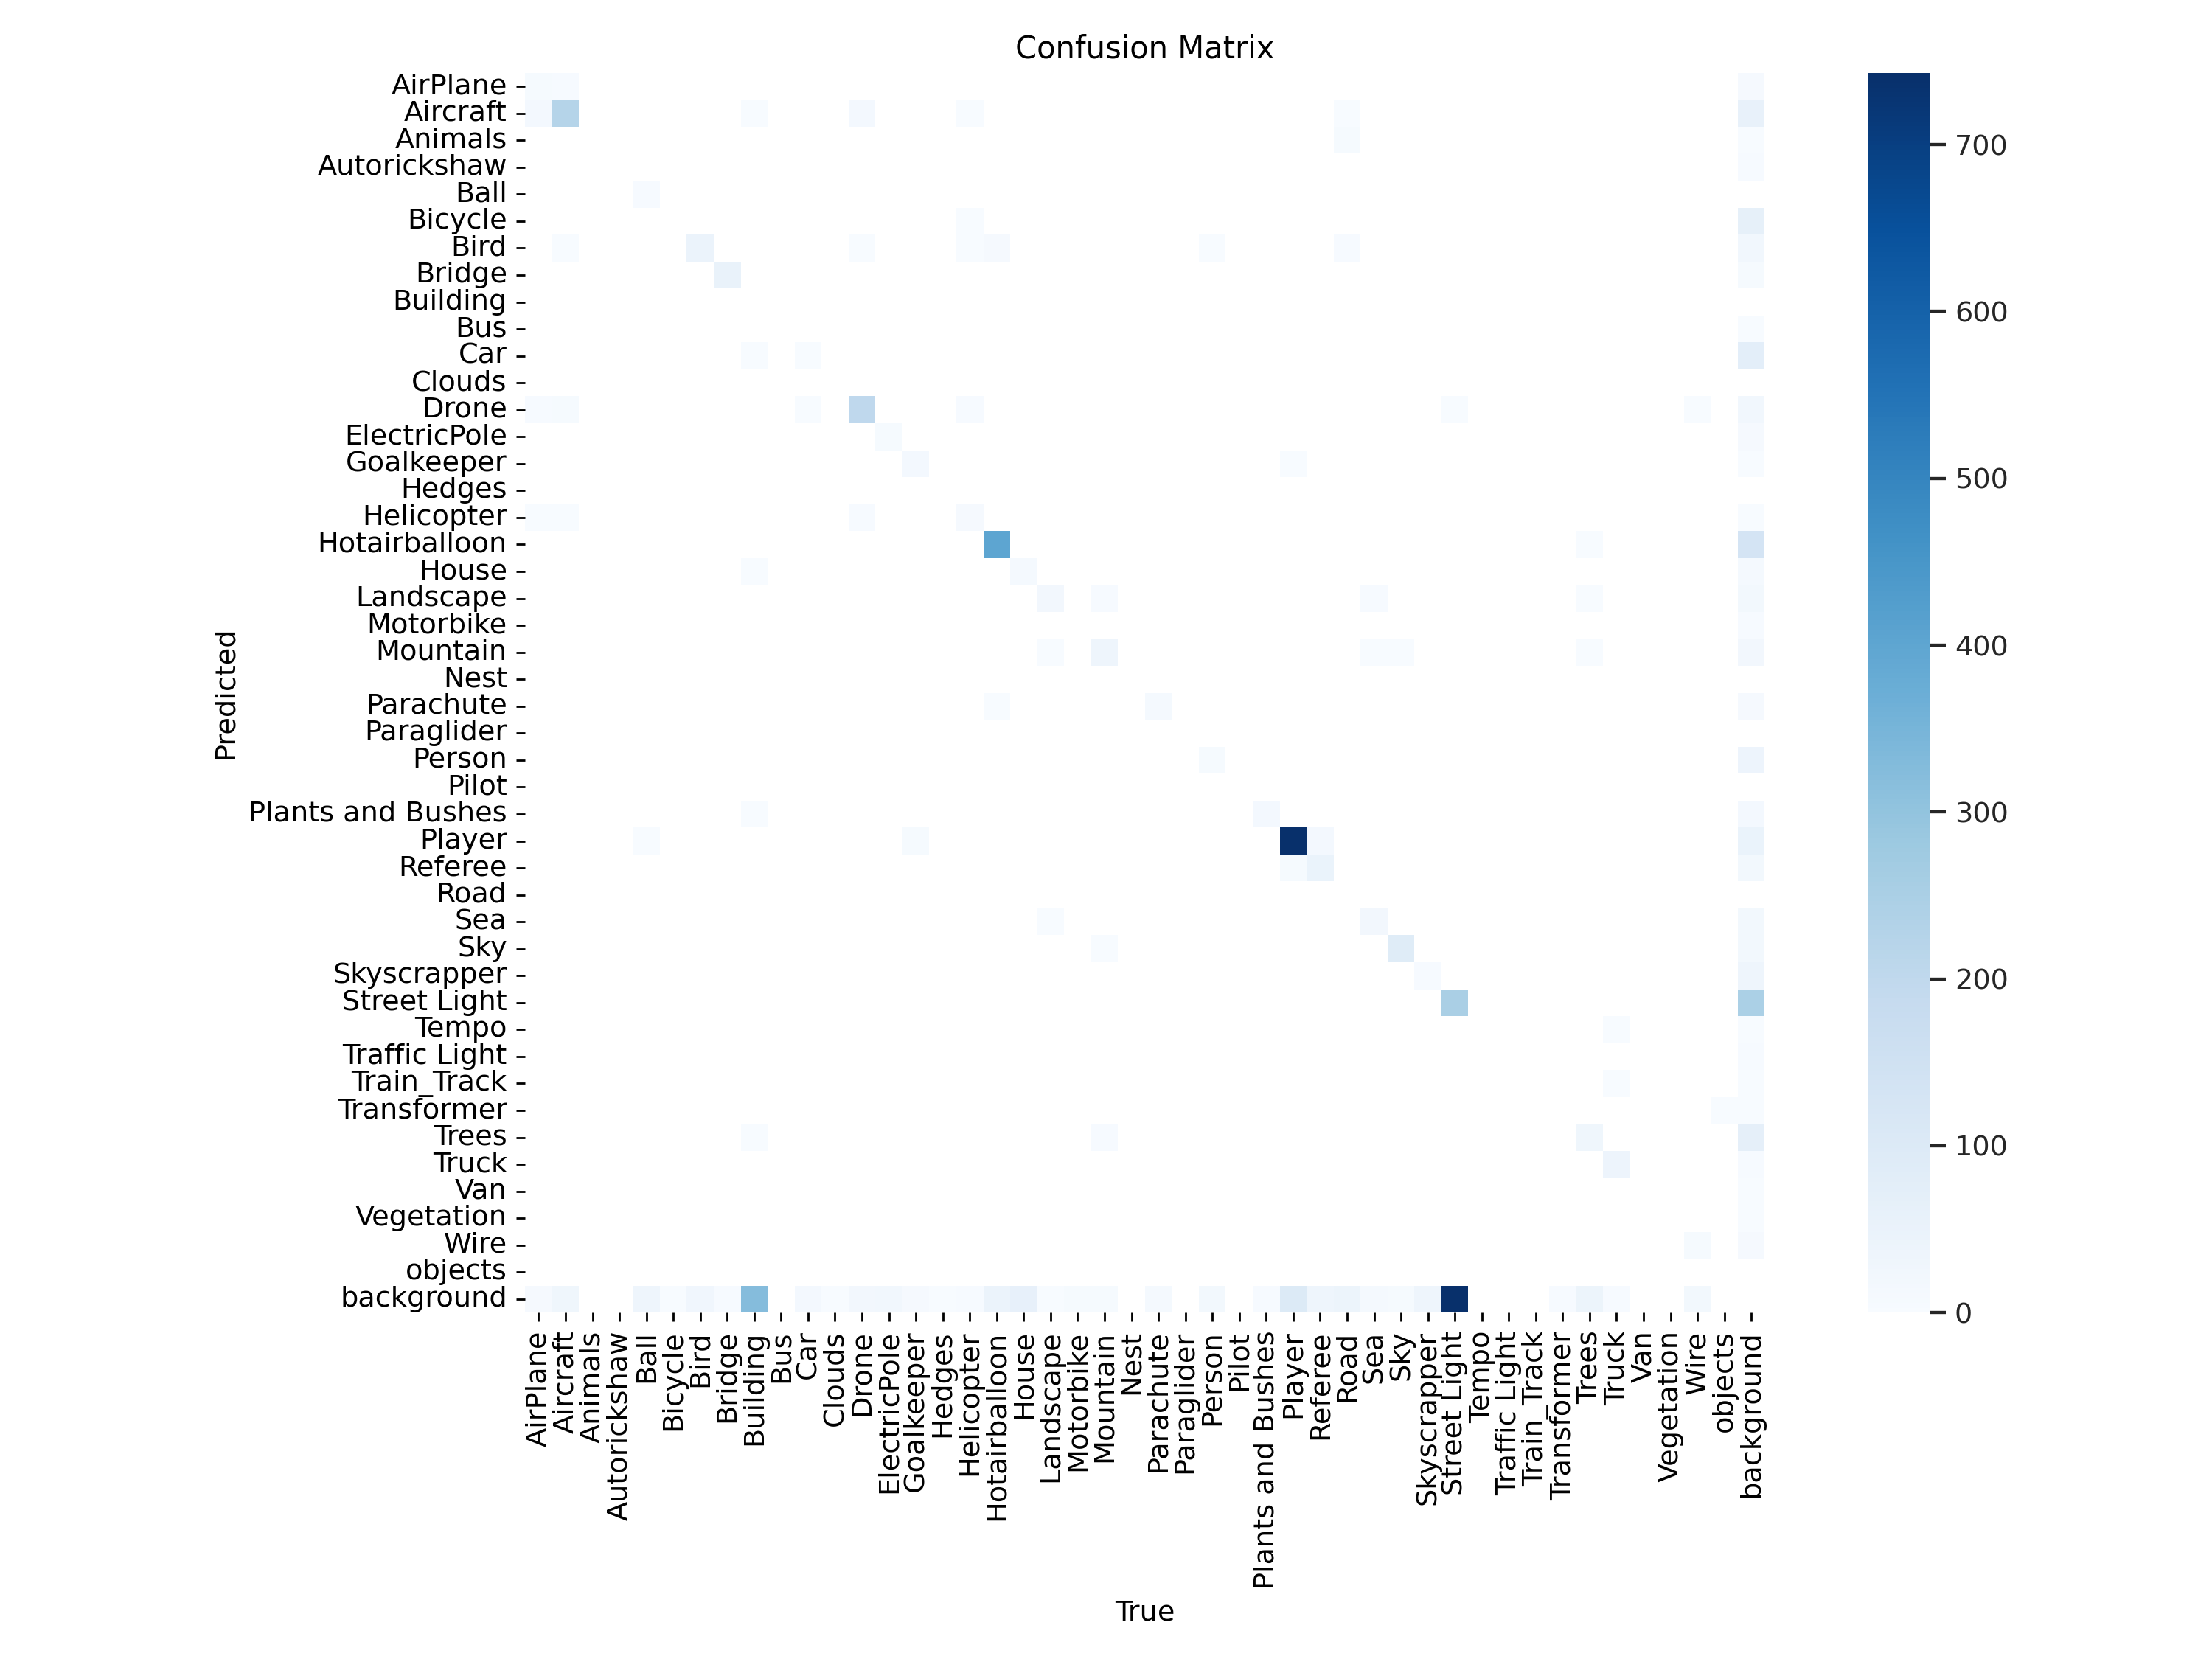

In [16]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1500)

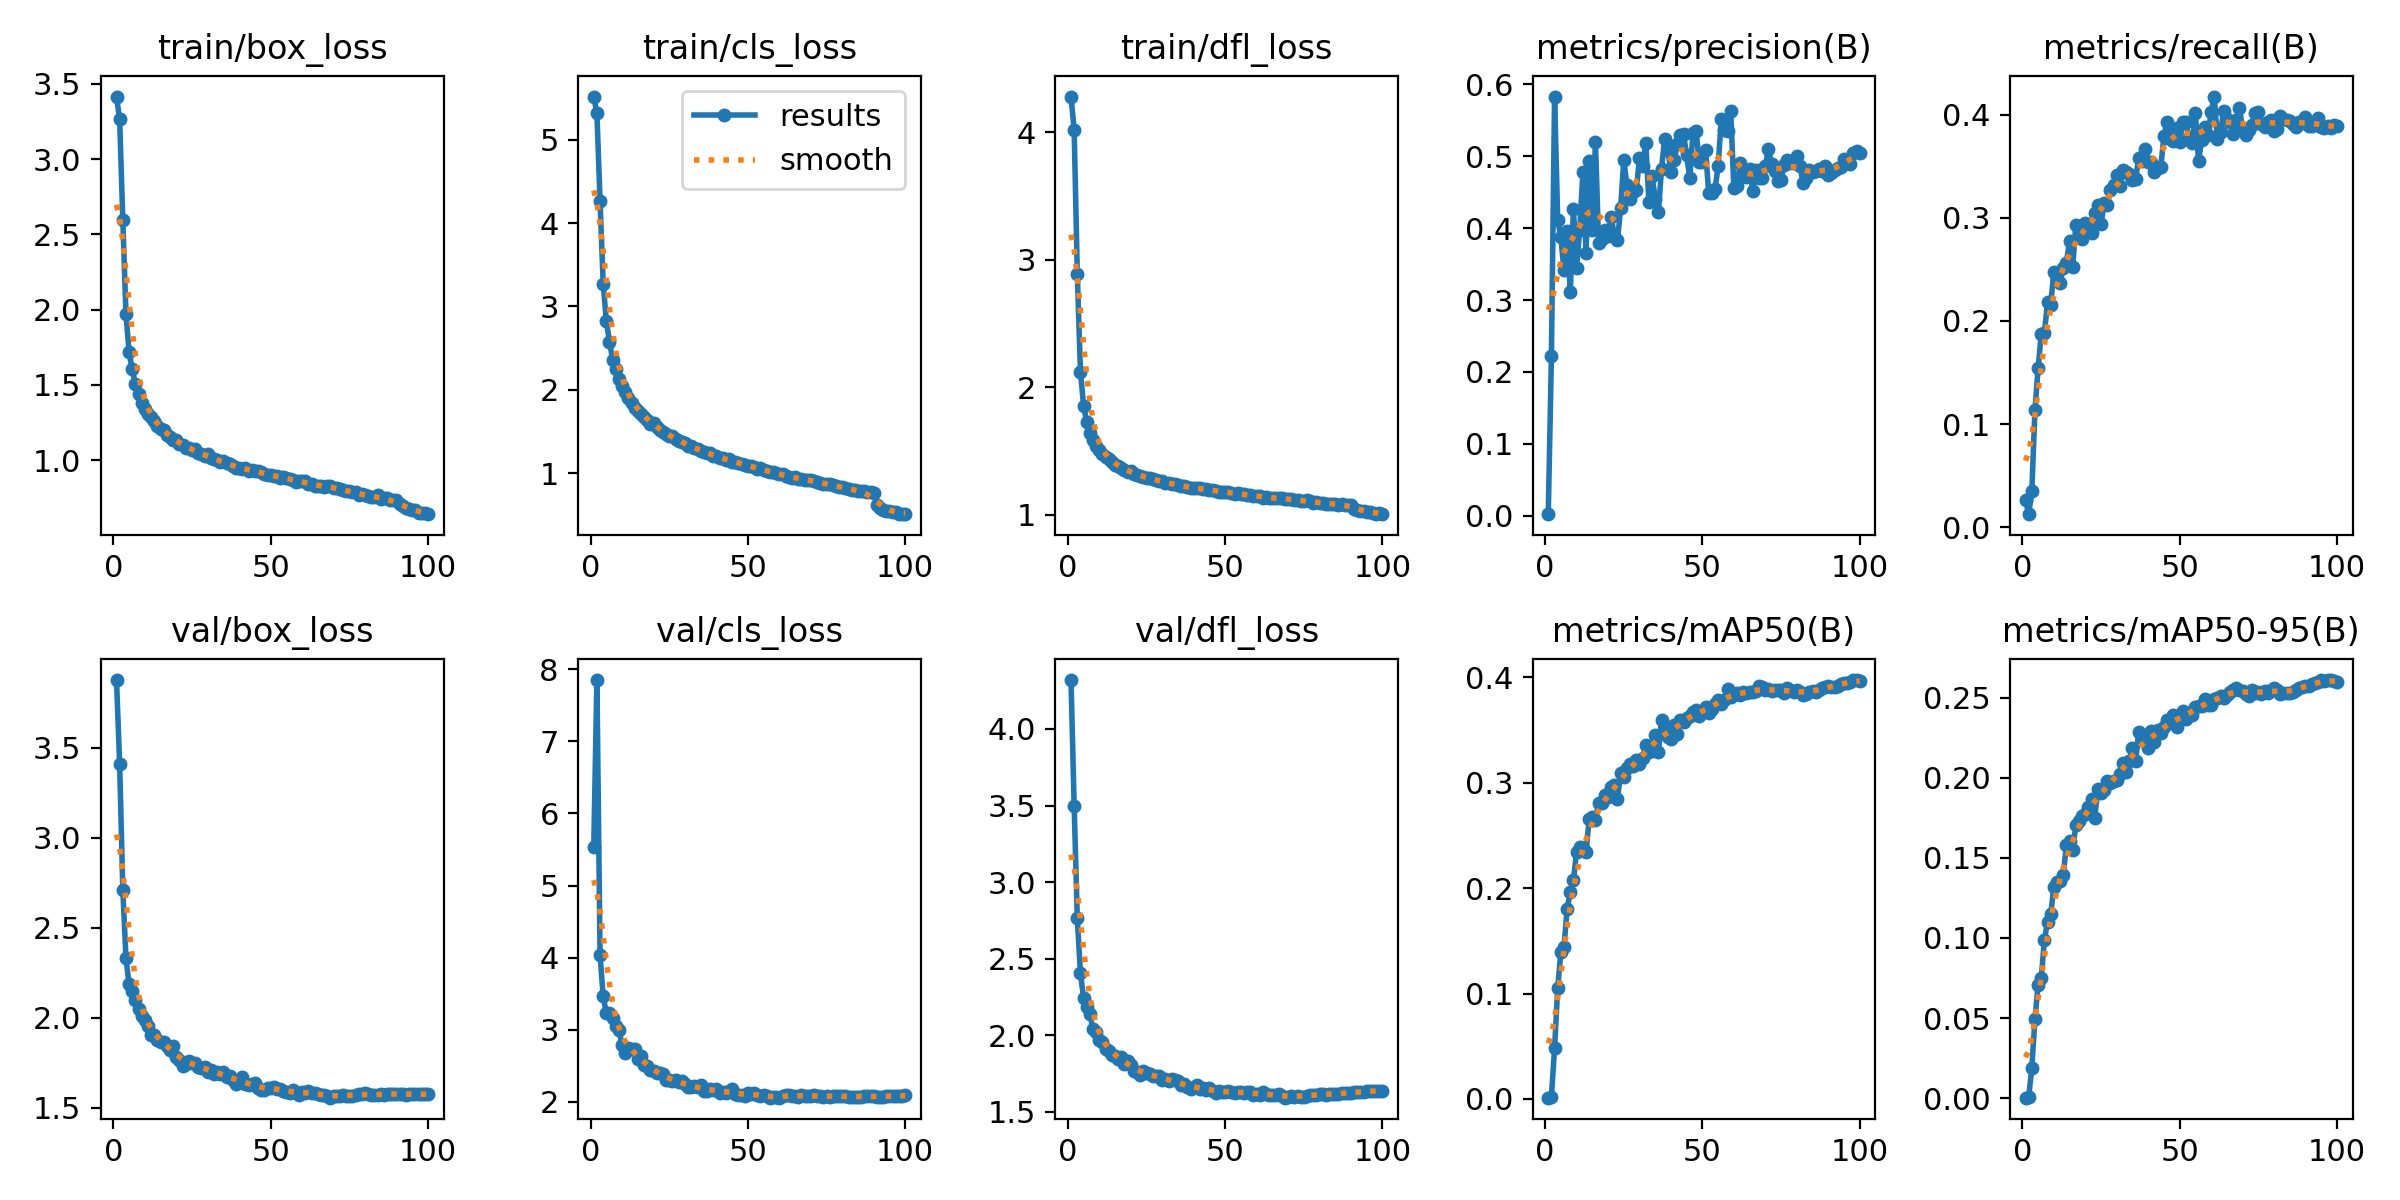

In [17]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [18]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['AirPlane',
 'Aircraft',
 'Animals',
 'Autorickshaw',
 'Ball',
 'Bicycle',
 'Bird',
 'Bridge',
 'Building',
 'Bus',
 'Car',
 'Clouds',
 'Drone',
 'ElectricPole',
 'Goalkeeper',
 'Hedges',
 'Helicopter',
 'Hotairballoon',
 'House',
 'Landscape',
 'Motorbike',
 'Mountain',
 'Nest',
 'Parachute',
 'Paraglider',
 'Person',
 'Pilot',
 'Plants and Bushes',
 'Player',
 'Referee',
 'Road',
 'Sea',
 'Sky',
 'Skyscrapper',
 'Street Light',
 'Tempo',
 'Traffic Light',
 'Train_Track',
 'Transformer',
 'Trees',
 'Truck',
 'Van',
 'Vegetation',
 'Wire',
 'objects']

In [19]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [20]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3026784625172089
mAP 50 0.425598401128286
mAP 75 0.3400512149865559


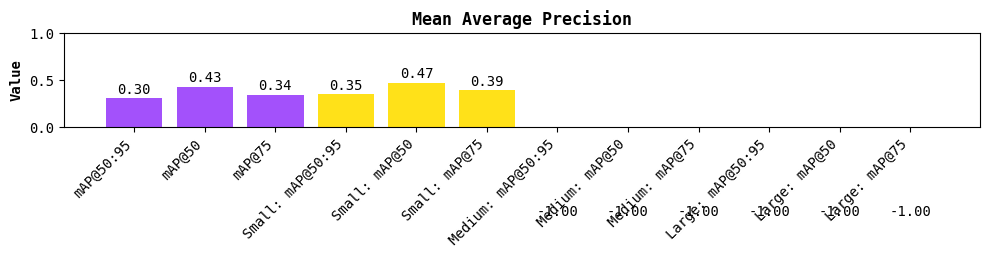

In [21]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [22]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

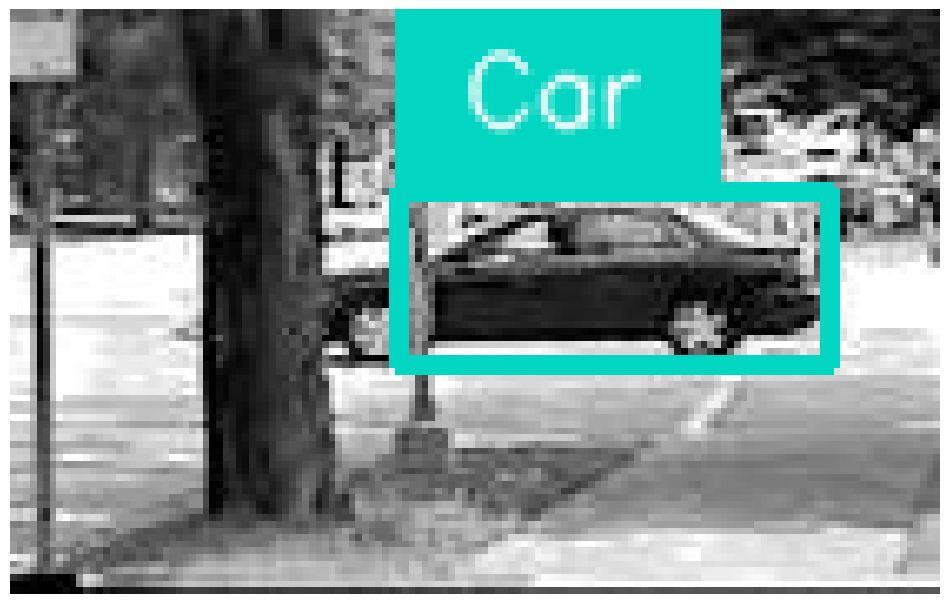

In [23]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

>>> STAGE 0: Installing Ultralytics and setting up environment <<<
✅ Environment setup complete.

>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<
✅ Loaded model: yolov12n.pt with 80 classes.
✅ Loaded model: best.pt with 45 classes.

--- Class Analysis ---
Default model classes: 80
Custom model classes: 45

✅ Common classes handled by default model: None
✅ Specialist classes handled by custom model: ['Person', 'Building', 'Pilot', 'House', 'Train_Track', 'Drone', 'AirPlane', 'Paraglider', 'Plants and Bushes', 'Bird', 'Tempo', 'Traffic Light', 'Street Light', 'Sea', 'Bus', 'Hedges', 'Referee', 'Autorickshaw', 'Ball', 'Clouds', 'Wire', 'Vegetation', 'Road', 'Skyscrapper', 'Goalkeeper', 'Aircraft', 'Helicopter', 'Bridge', 'ElectricPole', 'Animals', 'Hotairballoon', 'Trees', 'Sky', 'objects', 'Motorbike', 'Landscape', 'Parachute', 'Mountain', 'Player', 'Car', 'Van', 'Nest', 'Transformer', 'Bicycle', 'Truck']
----------------------

Running default model to detect its 80 kno

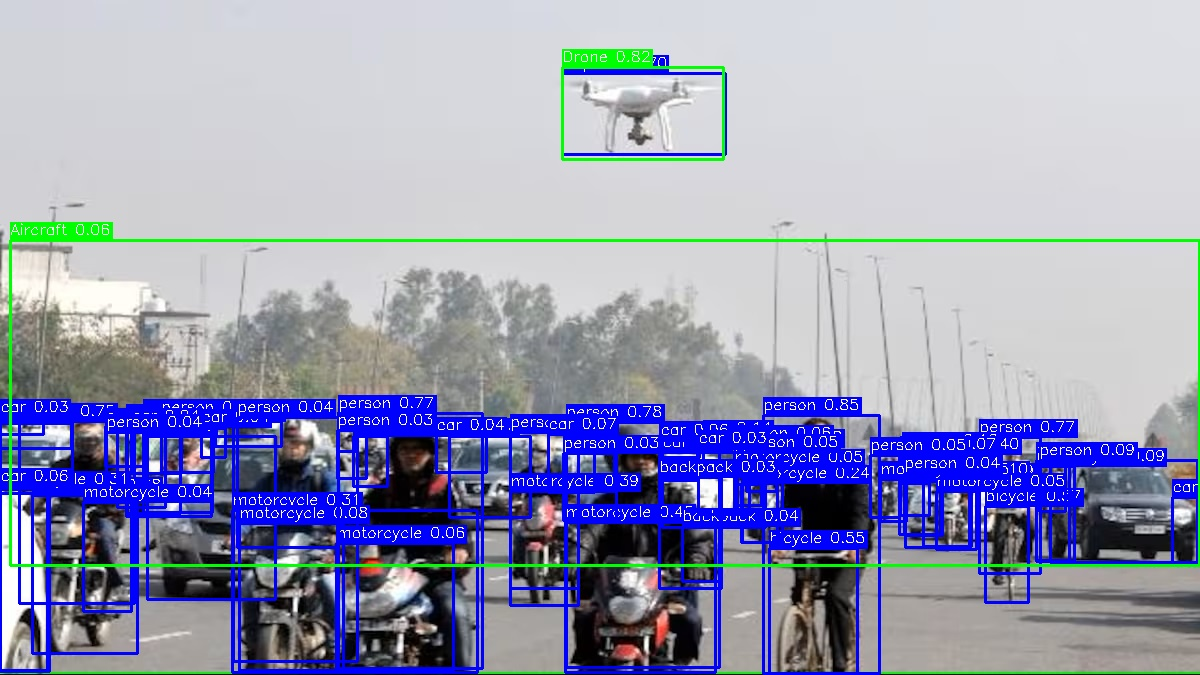

In [29]:
# ---
# STAGE 0: SETUP
# ---
print(">>> STAGE 0: Installing Ultralytics and setting up environment <<<")
# Install the required library for YOLOv8
!pip install ultralytics -q

import os
import cv2
import torch
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import Image, display

print("✅ Environment setup complete.")

# ---
# STAGE 1: HYBRID DETECTION SCRIPT
# ---
print("\n>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<")

# --- Configuration ---
# Create a project directory to keep things tidy
PROJECT_DIR = '/content/yolov12_hybrid_project'
os.makedirs(os.path.join(PROJECT_DIR, 'weights'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, 'data'), exist_ok=True)

DEFAULT_WEIGHTS_PATH = '/content/yolov12n.pt'
CUSTOM_WEIGHTS_PATH = '/content/runs/detect/train/weights/best.pt' # Your custom trained model
SOURCE_IMAGE_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Hybrid_Detection_Result.jpg"

# Detection parameters
CONFIDENCE_THRESHOLD = 0.03
IOU_THRESHOLD = 0.45

def load_yolo_model(weights_path):
    """Loads a YOLOv8 model from the specified path."""
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}")
    model = YOLO(weights_path)
    print(f"✅ Loaded model: {os.path.basename(weights_path)} with {len(model.model.names)} classes.")
    return model

def analyze_model_classes(model_default, model_custom):
    """Compares class lists and identifies unique and common classes."""
    default_classes = set(model_default.model.names.values())
    custom_classes = set(model_custom.model.names.values())

    unique_custom_classes = list(custom_classes - default_classes)
    common_classes = list(custom_classes.intersection(default_classes))

    print("\n--- Class Analysis ---")
    print(f"Default model classes: {len(default_classes)}")
    print(f"Custom model classes: {len(custom_classes)}")
    print(f"\n✅ Common classes handled by default model: {common_classes if common_classes else 'None'}")
    print(f"✅ Specialist classes handled by custom model: {unique_custom_classes if unique_custom_classes else 'None'}")
    print("----------------------\n")

    # Get the integer indices for the unique custom classes needed for prediction
    custom_names_map = {name: i for i, name in model_custom.model.names.items()}
    unique_custom_indices = [custom_names_map[name] for name in unique_custom_classes]

    return unique_custom_indices, unique_custom_classes

def visualize_results(frame, detections):
    """Draws bounding boxes on the frame with color-coding."""
    annotated_frame = frame.copy()
    for det in detections:
        xyxy = det['xyxy']
        label = f"{det['name']} {det['conf']:.2f}"

        # Blue for default model, Green for the custom specialist model
        color = (0, 255, 0) if det['source'] == 'custom_specialist' else (255, 0, 0)

        # Draw rectangle
        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)

        # Draw label
        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1] - text_height - baseline), (xyxy[0] + text_width, xyxy[1]), color, -1)
        cv2.putText(annotated_frame, label, (xyxy[0], xyxy[1] - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return annotated_frame

def setup_dummy_files():
    """Creates dummy model weights and an image for demonstration."""
    print("\n>>> Setting up dummy files for demonstration <<<")

    # Download default YOLOv8n weights if they don't exist
    if not os.path.exists(DEFAULT_WEIGHTS_PATH):
        print(f"Downloading default model to {DEFAULT_WEIGHTS_PATH}...")
        YOLO('yolov8n.pt').export(format='torchscript') # A simple way to trigger download and save
        os.rename('yolov8n.torchscript', DEFAULT_WEIGHTS_PATH)

    # For demonstration, we copy the default model to act as our "custom" model.
    # The class analysis will correctly show there are NO unique custom classes.
    if not os.path.exists(CUSTOM_WEIGHTS_PATH):
        print(f"Creating a dummy custom model at {CUSTOM_WEIGHTS_PATH}...")
        print("NOTE: For this demo, the custom model has the same classes as the default.")
        shutil.copy(DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH)

    # Create a dummy image if it doesn't exist
    if not os.path.exists(SOURCE_IMAGE_PATH):
        print(f"Creating a dummy source image at {SOURCE_IMAGE_PATH}...")
        PILImage.new('RGB', (1280, 720), color=(128, 128, 128)).save(SOURCE_IMAGE_PATH)

    print("✅ Dummy files are ready.")

def main():
    # Ensure all required files exist, or set up dummy ones
    if not all(os.path.exists(p) for p in [CUSTOM_WEIGHTS_PATH, SOURCE_IMAGE_PATH]):
        setup_dummy_files()

    # Load models
    model_default = load_yolo_model(DEFAULT_WEIGHTS_PATH)
    model_custom = load_yolo_model(CUSTOM_WEIGHTS_PATH)

    # Analyze classes to determine the specialist model's role
    unique_custom_indices, unique_custom_names = analyze_model_classes(model_default, model_custom)

    # Load image
    frame = cv2.imread(SOURCE_IMAGE_PATH)
    if frame is None:
        print(f"❌ Error: Failed to load source image from {SOURCE_IMAGE_PATH}")
        return

    # --- Run Detection ---
    final_detections = []

    # 1. Run the default model for general object detection
    print(f"Running default model to detect its {len(model_default.model.names)} known classes...")
    default_results = model_default.predict(
        source=frame, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD, verbose=False
    )
    # Process results from the default model
    for box in default_results[0].boxes:
        final_detections.append({
            'xyxy': [int(coord) for coord in box.xyxy[0].tolist()],
            'conf': box.conf[0].item(),
            'name': model_default.model.names[int(box.cls[0].item())],
            'source': 'default_general'
        })
    print(f"Default model found {len(final_detections)} objects.")

    # 2. Run the custom model ONLY for its unique classes
    if unique_custom_indices:
        print(f"Running custom specialist model to detect ONLY: {unique_custom_names}...")
        custom_results = model_custom.predict(
            source=frame, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD, classes=unique_custom_indices, verbose=False
        )
        # Process results from the custom model
        custom_count = 0
        for box in custom_results[0].boxes:
            custom_count += 1
            final_detections.append({
                'xyxy': [int(coord) for coord in box.xyxy[0].tolist()],
                'conf': box.conf[0].item(),
                'name': model_custom.model.names[int(box.cls[0].item())],
                'source': 'custom_specialist'
            })
        print(f"Custom specialist model added {custom_count} unique objects.")
    else:
        print("No unique classes for the custom model to detect. Skipping specialist prediction.")

    # Visualize and save the combined results
    print(f"\nTotal combined detections: {len(final_detections)}")
    result_frame = visualize_results(frame, final_detections)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"\n✅ Hybrid detection complete. Results saved to {OUTPUT_PATH}")
    display(Image(filename=OUTPUT_PATH, width=800))

if __name__ == "__main__":
    import shutil
    main()

>>> STAGE 0: Installing Ultralatytics and setting up environment <<<
✅ Environment setup complete.

>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<
✅ Loaded model: yolov12n.pt with 80 classes.
✅ Loaded model: best.pt with 45 classes.

--- Class Analysis ---
Default model classes: 80
Custom model classes: 45

✅ Common classes handled by default model: None
✅ Specialist classes handled by custom model: ['Person', 'Building', 'Pilot', 'House', 'Train_Track', 'Drone', 'AirPlane', 'Paraglider', 'Plants and Bushes', 'Bird', 'Tempo', 'Traffic Light', 'Street Light', 'Sea', 'Bus', 'Hedges', 'Referee', 'Autorickshaw', 'Ball', 'Clouds', 'Wire', 'Vegetation', 'Road', 'Skyscrapper', 'Goalkeeper', 'Aircraft', 'Helicopter', 'Bridge', 'ElectricPole', 'Animals', 'Hotairballoon', 'Trees', 'Sky', 'objects', 'Motorbike', 'Landscape', 'Parachute', 'Mountain', 'Player', 'Car', 'Van', 'Nest', 'Transformer', 'Bicycle', 'Truck']
----------------------

Running default model...
Default model f

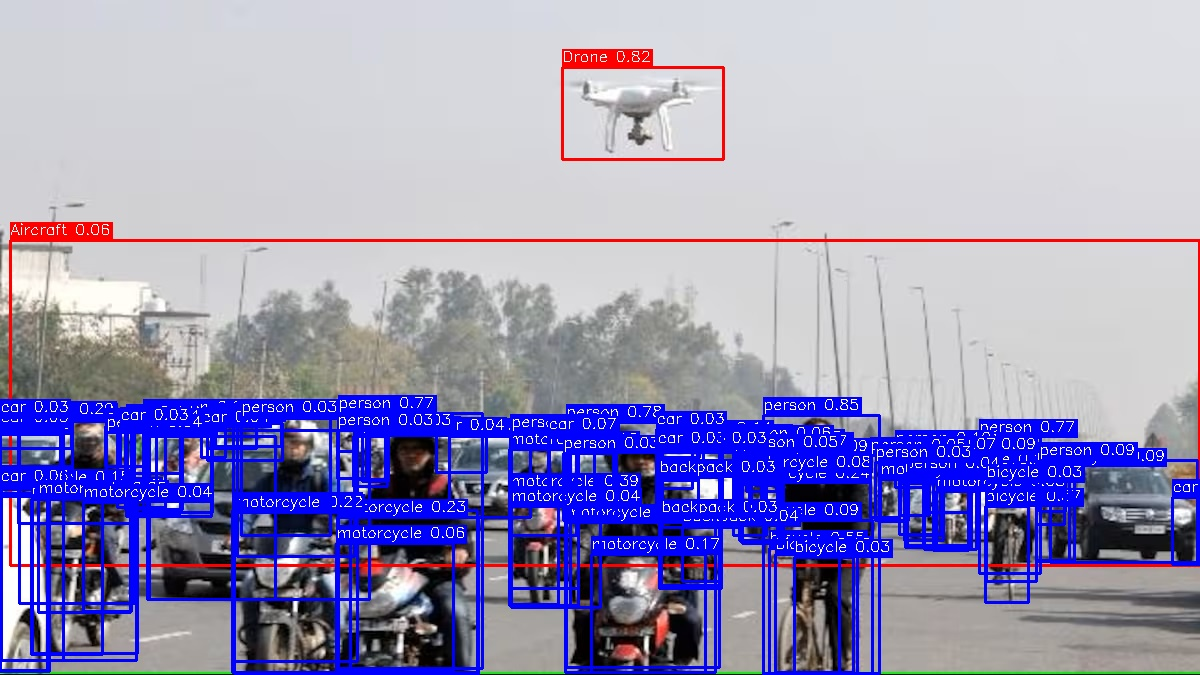

In [30]:
# ---
# STAGE 0: SETUP
# ---
print(">>> STAGE 0: Installing Ultralatytics and setting up environment <<<")
!pip install ultralytics -q

import os
import cv2
import torch
import shutil
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import Image, display

print("✅ Environment setup complete.")

# ---
# STAGE 1: HYBRID DETECTION SCRIPT WITH PRIORITY NMS
# ---
print("\n>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<")

# --- Configuration ---
# Updated paths as per your request
DEFAULT_WEIGHTS_PATH = '/content/yolov12n.pt'
CUSTOM_WEIGHTS_PATH = '/content/runs/detect/train/weights/best.pt'
SOURCE_IMAGE_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Hybrid_Detection_Result.jpg"

# Create directories for source and output if they don't exist
os.makedirs(os.path.dirname(SOURCE_IMAGE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CUSTOM_WEIGHTS_PATH), exist_ok=True)
os.makedirs(os.path.dirname(DEFAULT_WEIGHTS_PATH), exist_ok=True)


# Updated detection parameters
CONFIDENCE_THRESHOLD = 0.03
IOU_THRESHOLD = 0.45  # IoU threshold for the Priority NMS step

def load_yolo_model(weights_path):
    """Loads a YOLOv8 model from the specified path."""
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}")
    model = YOLO(weights_path)
    print(f"✅ Loaded model: {os.path.basename(weights_path)} with {len(model.model.names)} classes.")
    return model

def analyze_model_classes(model_default, model_custom):
    """Compares class lists and identifies unique and common classes."""
    default_classes = set(model_default.model.names.values())
    custom_classes = set(model_custom.model.names.values())

    unique_custom_classes = list(custom_classes - default_classes)
    common_classes = list(custom_classes.intersection(default_classes))

    print("\n--- Class Analysis ---")
    print(f"Default model classes: {len(default_classes)}")
    print(f"Custom model classes: {len(custom_classes)}")
    print(f"\n✅ Common classes handled by default model: {common_classes if common_classes else 'None'}")
    print(f"✅ Specialist classes handled by custom model: {unique_custom_classes if unique_custom_classes else 'None'}")
    print("----------------------\n")

    custom_names_map = {name: i for i, name in model_custom.model.names.items()}
    unique_custom_indices = [custom_names_map[name] for name in unique_custom_classes]

    return unique_custom_indices, unique_custom_classes

def calculate_iou(box1_xyxy, box2_xyxy):
    """Calculate Intersection over Union between two bounding boxes."""
    x1 = max(box1_xyxy[0], box2_xyxy[0])
    y1 = max(box1_xyxy[1], box2_xyxy[1])
    x2 = min(box1_xyxy[2], box2_xyxy[2])
    y2 = min(box1_xyxy[3], box2_xyxy[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1_xyxy[2] - box1_xyxy[0]) * (box1_xyxy[3] - box1_xyxy[1])
    box2_area = (box2_xyxy[2] - box2_xyxy[0]) * (box2_xyxy[3] - box2_xyxy[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def visualize_results(frame, detections):
    """Draws bounding boxes on the frame with color-coding."""
    annotated_frame = frame.copy()
    for det in detections:
        xyxy = det['xyxy']
        label = f"{det['name']} {det['conf']:.2f}"

        # Red for custom specialist, Blue for default model
        color = (0, 0, 255) if det['source'] == 'custom_specialist' else (255, 0, 0)

        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)

        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1] - text_height - baseline), (xyxy[0] + text_width, xyxy[1]), color, -1)
        cv2.putText(annotated_frame, label, (xyxy[0], xyxy[1] - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return annotated_frame

def setup_dummy_files():
    """Creates dummy model weights and an image for demonstration."""
    print("\n>>> Setting up dummy files for demonstration <<<")

    if not os.path.exists(DEFAULT_WEIGHTS_PATH):
        print(f"Downloading default model to {DEFAULT_WEIGHTS_PATH}...")
        # A simple trick to download and save the model as yolov12n.pt
        temp_model = YOLO('yolov8n.pt')
        shutil.move('yolov8n.pt', DEFAULT_WEIGHTS_PATH)

    if not os.path.exists(CUSTOM_WEIGHTS_PATH):
        print(f"Creating a dummy custom model at {CUSTOM_WEIGHTS_PATH}...")
        print("NOTE: For this demo, the custom model has the same classes as the default.")
        shutil.copy(DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH)

    if not os.path.exists(SOURCE_IMAGE_PATH):
        print(f"Creating a dummy source image at {SOURCE_IMAGE_PATH}...")
        PILImage.new('RGB', (1280, 720), color=(128, 128, 128)).save(SOURCE_IMAGE_PATH)

    print("✅ Dummy files are ready.")

def main():
    # Setup dummy files if real ones don't exist
    if not all(os.path.exists(p) for p in [DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH, SOURCE_IMAGE_PATH]):
        setup_dummy_files()

    model_default = load_yolo_model(DEFAULT_WEIGHTS_PATH)
    model_custom = load_yolo_model(CUSTOM_WEIGHTS_PATH)

    unique_custom_indices, unique_custom_names = analyze_model_classes(model_default, model_custom)

    frame = cv2.imread(SOURCE_IMAGE_PATH)
    if frame is None:
        print(f"❌ Error: Failed to load source image from {SOURCE_IMAGE_PATH}")
        return

    # --- Run Detection ---
    default_detections = []
    specialist_detections = []

    # 1. Run the default model for general object detection
    print(f"Running default model...")
    default_results = model_default.predict(
        source=frame, conf=CONFIDENCE_THRESHOLD, verbose=False
    )
    for box in default_results[0].boxes:
        default_detections.append({
            'xyxy': [int(c) for c in box.xyxy[0].tolist()],
            'conf': box.conf[0].item(),
            'name': model_default.model.names[int(box.cls[0].item())],
            'source': 'default_general'
        })
    print(f"Default model found {len(default_detections)} potential objects.")

    # 2. Run the custom model ONLY for its unique classes
    if unique_custom_indices:
        print(f"Running custom specialist model to detect ONLY: {unique_custom_names}...")
        custom_results = model_custom.predict(
            source=frame, conf=CONFIDENCE_THRESHOLD, classes=unique_custom_indices, verbose=False
        )
        for box in custom_results[0].boxes:
            specialist_detections.append({
                'xyxy': [int(c) for c in box.xyxy[0].tolist()],
                'conf': box.conf[0].item(),
                'name': model_custom.model.names[int(box.cls[0].item())],
                'source': 'custom_specialist'
            })
        print(f"Custom specialist model found {len(specialist_detections)} unique objects.")
    else:
        print("No unique classes for the custom model to detect. Skipping specialist prediction.")

    # 3. Priority NMS: Filter default detections that overlap with specialist detections
    filtered_default_detections = []
    if specialist_detections:
        print("\nApplying Priority NMS to remove overlapping default boxes...")
        for default_det in default_detections:
            is_suppressed = False
            for specialist_det in specialist_detections:
                if calculate_iou(default_det['xyxy'], specialist_det['xyxy']) > IOU_THRESHOLD:
                    is_suppressed = True
                    break
            if not is_suppressed:
                filtered_default_detections.append(default_det)

        suppressed_count = len(default_detections) - len(filtered_default_detections)
        print(f"Suppressed {suppressed_count} default detection(s) that overlapped with specialist detections.")
    else:
        # If no specialist detections, keep all default detections
        filtered_default_detections = default_detections

    # 4. Combine the results
    final_detections = specialist_detections + filtered_default_detections

    # Visualize and save
    print(f"\nTotal combined detections after filtering: {len(final_detections)}")
    result_frame = visualize_results(frame, final_detections)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"\n✅ Hybrid detection complete. Results saved to {OUTPUT_PATH}")
    display(Image(filename=OUTPUT_PATH, width=800))

if __name__ == "__main__":
    main()

>>> STAGE 0: Installing Ultralytics and setting up environment <<<
✅ Environment setup complete.

>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<
✅ Loaded model: yolov12n.pt with 80 classes.
✅ Loaded model: best.pt with 45 classes.

--- Class Analysis & Task Delegation ---
Found 8 common classes. Task delegated to: DEFAULT model.
  -> ['airplane', 'bicycle', 'bird', 'bus', 'car', 'person', 'traffic light', 'truck']
Found 37 unique specialist classes. Task delegated to: CUSTOM model.
  -> ['aircraft', 'animals', 'autorickshaw', 'ball', 'bridge', 'building', 'clouds', 'drone', 'electricpole', 'goalkeeper', 'hedges', 'helicopter', 'hotairballoon', 'house', 'landscape', 'motorbike', 'mountain', 'nest', 'objects', 'parachute', 'paraglider', 'pilot', 'plants and bushes', 'player', 'referee', 'road', 'sea', 'sky', 'skyscrapper', 'street light', 'tempo', 'train_track', 'transformer', 'trees', 'van', 'vegetation', 'wire']
----------------------------------------

Running defaul

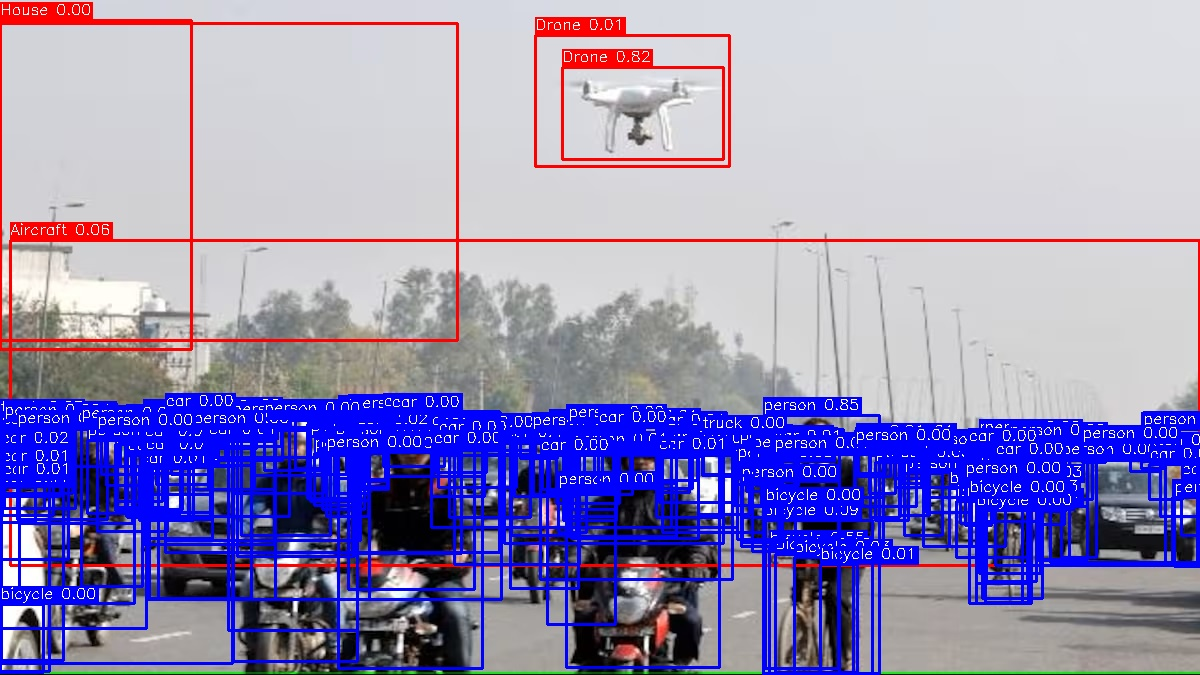

In [32]:
# ---
# STAGE 0: SETUP
# ---
print(">>> STAGE 0: Installing Ultralytics and setting up environment <<<")
!pip install ultralytics -q

import os
import cv2
import torch
import shutil
import numpy as np
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import Image, display

print("✅ Environment setup complete.")

# ---
# STAGE 1: HYBRID DETECTION SCRIPT WITH CLASS-BASED TASK DIVISION & PRIORITY NMS
# ---
print("\n>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<")

# --- Configuration ---
# Define the class lists provided by the user
CUSTOM_MODEL_CLASSES = [
    'AirPlane', 'Aircraft', 'Animals', 'Autorickshaw', 'Ball', 'Bicycle', 'Bird',
    'Bridge', 'Building', 'Bus', 'Car', 'Clouds', 'Drone', 'ElectricPole',
    'Goalkeeper', 'Hedges', 'Helicopter', 'Hotairballoon', 'House', 'Landscape',
    'Motorbike', 'Mountain', 'Nest', 'Parachute', 'Paraglider', 'Person', 'Pilot',
    'Plants and Bushes', 'Player', 'Referee', 'Road', 'Sea', 'Sky', 'Skyscrapper',
    'Street Light', 'Tempo', 'Traffic Light', 'Train_Track', 'Transformer',
    'Trees', 'Truck', 'Van', 'Vegetation', 'Wire', 'objects'
]
DEFAULT_MODEL_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Define file paths
DEFAULT_WEIGHTS_PATH = '/content/yolov12n.pt'
CUSTOM_WEIGHTS_PATH = '/content/runs/detect/train/weights/best.pt'
SOURCE_IMAGE_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Hybrid_Detection_Result.jpg"

# Create directories if they don't exist
os.makedirs(os.path.dirname(SOURCE_IMAGE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CUSTOM_WEIGHTS_PATH), exist_ok=True)

# Detection parameters
CONFIDENCE_THRESHOLD = 0.003
IOU_THRESHOLD = 0.45  # IoU threshold for the Priority NMS step

def load_yolo_model(weights_path):
    """Loads a YOLOv8 model from the specified path."""
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}")
    model = YOLO(weights_path)
    print(f"✅ Loaded model: {os.path.basename(weights_path)} with {len(model.model.names)} classes.")
    return model

def analyze_and_get_class_indices(default_model, custom_model):
    """
    Analyzes user-defined class lists to determine which model detects what.
    Returns the integer indices for targeted prediction.
    """
    # Normalize all class names to lowercase for accurate comparison
    default_names_lower = {c.lower().strip() for c in DEFAULT_MODEL_CLASSES}
    custom_names_lower = {c.lower().strip() for c in CUSTOM_MODEL_CLASSES}

    common_names = default_names_lower.intersection(custom_names_lower)
    unique_custom_names = custom_names_lower - default_names_lower

    print("\n--- Class Analysis & Task Delegation ---")
    print(f"Found {len(common_names)} common classes. Task delegated to: DEFAULT model.")
    print(f"  -> {sorted(list(common_names))}")
    print(f"Found {len(unique_custom_names)} unique specialist classes. Task delegated to: CUSTOM model.")
    print(f"  -> {sorted(list(unique_custom_names))}")
    print("----------------------------------------\n")

    # Create name-to-index mappings from the loaded models
    default_name_to_idx = {name.lower(): i for i, name in default_model.model.names.items()}
    custom_name_to_idx = {name.lower(): i for i, name in custom_model.model.names.items()}

    # Get integer indices for prediction
    common_indices_for_default = [default_name_to_idx[name] for name in common_names if name in default_name_to_idx]
    unique_indices_for_custom = [custom_name_to_idx[name] for name in unique_custom_names if name in custom_name_to_idx]

    return common_indices_for_default, unique_indices_for_custom, sorted(list(unique_custom_names))

def calculate_iou(box1_xyxy, box2_xyxy):
    """Calculate Intersection over Union between two bounding boxes."""
    x1 = max(box1_xyxy[0], box2_xyxy[0])
    y1 = max(box1_xyxy[1], box2_xyxy[1])
    x2 = min(box1_xyxy[2], box2_xyxy[2])
    y2 = min(box1_xyxy[3], box2_xyxy[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1_xyxy[2] - box1_xyxy[0]) * (box1_xyxy[3] - box1_xyxy[1])
    box2_area = (box2_xyxy[2] - box2_xyxy[0]) * (box2_xyxy[3] - box2_xyxy[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def visualize_results(frame, detections):
    """Draws bounding boxes on the frame with color-coding."""
    annotated_frame = frame.copy()
    for det in detections:
        xyxy = det['xyxy']
        label = f"{det['name']} {det['conf']:.2f}"

        # Red for custom specialist, Blue for default model
        color = (0, 0, 255) if det['source'] == 'custom_specialist' else (255, 0, 0)

        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)

        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1] - text_height - baseline), (xyxy[0] + text_width, xyxy[1]), color, -1)
        cv2.putText(annotated_frame, label, (xyxy[0], xyxy[1] - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return annotated_frame

def setup_dummy_files():
    """Creates dummy model weights and an image for demonstration."""
    print("\n>>> Setting up dummy files for demonstration <<<")

    if not os.path.exists(DEFAULT_WEIGHTS_PATH):
        print(f"Downloading default model to {DEFAULT_WEIGHTS_PATH}...")
        temp_model = YOLO('yolov8n.pt')
        shutil.move('yolov8n.pt', DEFAULT_WEIGHTS_PATH.replace('yolov12n.pt', 'yolov8n.pt'))
        os.rename(DEFAULT_WEIGHTS_PATH.replace('yolov12n.pt', 'yolov8n.pt'), DEFAULT_WEIGHTS_PATH)


    if not os.path.exists(CUSTOM_WEIGHTS_PATH):
        print(f"Creating a dummy custom model at {CUSTOM_WEIGHTS_PATH}...")
        print("NOTE: For this demo, the custom model is a copy of the default. The script will correctly identify NO unique classes.")
        shutil.copy(DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH)

    if not os.path.exists(SOURCE_IMAGE_PATH):
        print(f"Creating a dummy source image at {SOURCE_IMAGE_PATH}...")
        PILImage.new('RGB', (1280, 720), color=(128, 128, 128)).save(SOURCE_IMAGE_PATH)

    print("✅ Dummy files are ready.")

def main():
    if not all(os.path.exists(p) for p in [DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH, SOURCE_IMAGE_PATH]):
        setup_dummy_files()

    model_default = load_yolo_model(DEFAULT_WEIGHTS_PATH)
    model_custom = load_yolo_model(CUSTOM_WEIGHTS_PATH)

    common_indices, unique_indices, unique_names = analyze_and_get_class_indices(model_default, model_custom)

    frame = cv2.imread(SOURCE_IMAGE_PATH)
    if frame is None:
        print(f"❌ Error: Failed to load source image from {SOURCE_IMAGE_PATH}")
        return

    # --- Run Detection in Two Targeted Stages ---
    generalist_detections = []
    specialist_detections = []

    # 1. Run the default model ONLY for COMMON classes
    if common_indices:
        print(f"Running default model for {len(common_indices)} common classes...")
        default_results = model_default.predict(source=frame, conf=CONFIDENCE_THRESHOLD, classes=common_indices, verbose=False)
        for box in default_results[0].boxes:
            generalist_detections.append({
                'xyxy': [int(c) for c in box.xyxy[0].tolist()],
                'conf': box.conf[0].item(),
                'name': model_default.model.names[int(box.cls[0].item())],
                'source': 'default_general'
            })
        print(f"Default model found {len(generalist_detections)} potential objects.")
    else:
        print("No common classes to detect with default model.")

    # 2. Run the custom model ONLY for its UNIQUE classes
    if unique_indices:
        print(f"Running custom specialist model for unique classes: {unique_names}...")
        custom_results = model_custom.predict(source=frame, conf=CONFIDENCE_THRESHOLD, classes=unique_indices, verbose=False)
        for box in custom_results[0].boxes:
            specialist_detections.append({
                'xyxy': [int(c) for c in box.xyxy[0].tolist()],
                'conf': box.conf[0].item(),
                'name': model_custom.model.names[int(box.cls[0].item())],
                'source': 'custom_specialist'
            })
        print(f"Custom specialist model found {len(specialist_detections)} unique objects.")
    else:
        print("No unique classes for the custom model to detect. Skipping specialist prediction.")

    # 3. Priority NMS: Filter generalist detections that overlap with specialist detections
    filtered_generalist_detections = []
    if specialist_detections and generalist_detections:
        print("\nApplying Priority NMS to ensure specialist detections take precedence...")
        for gen_det in generalist_detections:
            is_suppressed = False
            for spec_det in specialist_detections:
                if calculate_iou(gen_det['xyxy'], spec_det['xyxy']) > IOU_THRESHOLD:
                    is_suppressed = True
                    break
            if not is_suppressed:
                filtered_generalist_detections.append(gen_det)

        suppressed_count = len(generalist_detections) - len(filtered_generalist_detections)
        print(f"Suppressed {suppressed_count} generalist detection(s) that overlapped with specialist detections.")
    else:
        filtered_generalist_detections = generalist_detections

    # 4. Combine the final, non-overlapping results
    final_detections = specialist_detections + filtered_generalist_detections

    # Visualize and save
    print(f"\nTotal combined detections after filtering: {len(final_detections)}")
    result_frame = visualize_results(frame, final_detections)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"\n✅ Hybrid detection complete. Results saved to {OUTPUT_PATH}")
    display(Image(filename=OUTPUT_PATH, width=800))

if __name__ == "__main__":
    main()

>>> STAGE 0: Installing Ultralytics and setting up environment <<<
✅ Environment setup complete.

>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<
✅ Loaded model: yolov12n.pt with 80 classes.
✅ Loaded model: best.pt with 45 classes.

--- Class Analysis & Task Delegation ---
Found 8 common classes. Task delegated to: DEFAULT model.
  -> ['airplane', 'bicycle', 'bird', 'bus', 'car', 'person', 'traffic light', 'truck']
Found 37 unique specialist classes. Task delegated to: CUSTOM model.
  -> ['aircraft', 'animals', 'autorickshaw', 'ball', 'bridge', 'building', 'clouds', 'drone', 'electricpole', 'goalkeeper', 'hedges', 'helicopter', 'hotairballoon', 'house', 'landscape', 'motorbike', 'mountain', 'nest', 'objects', 'parachute', 'paraglider', 'pilot', 'plants and bushes', 'player', 'referee', 'road', 'sea', 'sky', 'skyscrapper', 'street light', 'tempo', 'train_track', 'transformer', 'trees', 'van', 'vegetation', 'wire']
----------------------------------------

Running defaul

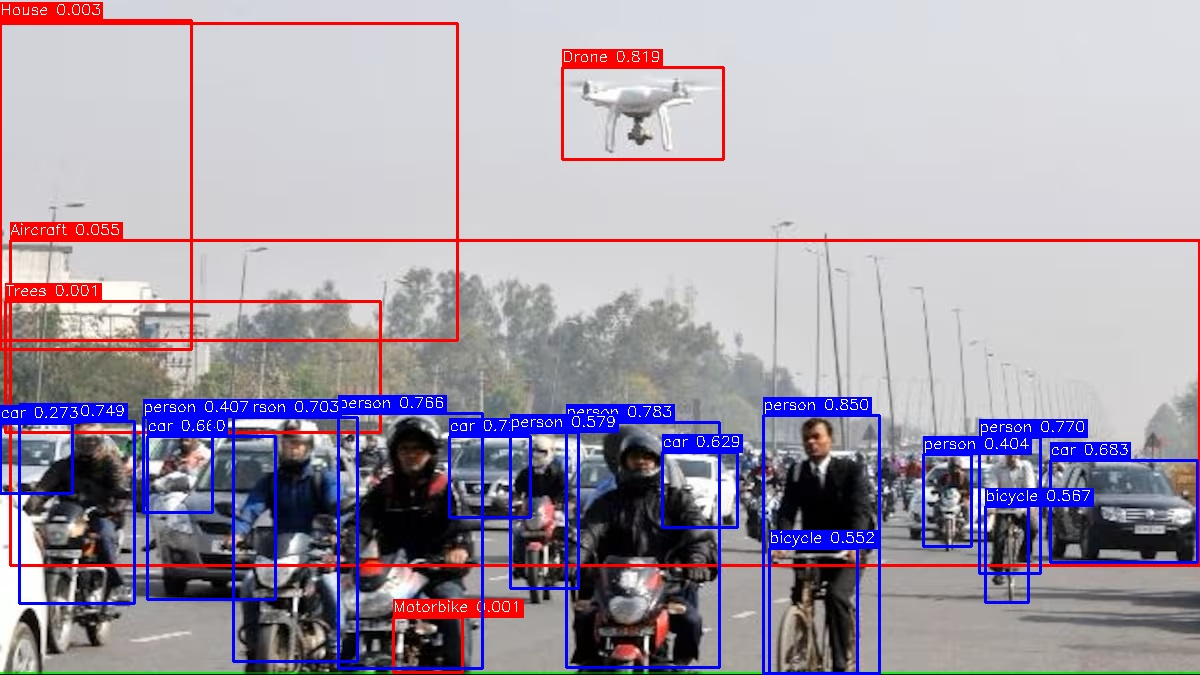

In [34]:
# ---
# STAGE 0: SETUP
# ---
print(">>> STAGE 0: Installing Ultralytics and setting up environment <<<")
!pip install ultralytics -q

import os
import cv2
import torch
import shutil
import numpy as np
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import Image, display

print("✅ Environment setup complete.")

# ---
# STAGE 1: HYBRID DETECTION SCRIPT WITH CLASS-BASED TASK DIVISION & PRIORITY NMS
# ---
print("\n>>> STAGE 1: Initializing Hybrid Detection Script for YOLOv8 <<<")

# --- Configuration ---
# Define the class lists provided by the user
CUSTOM_MODEL_CLASSES = [
    'AirPlane', 'Aircraft', 'Animals', 'Autorickshaw', 'Ball', 'Bicycle', 'Bird',
    'Bridge', 'Building', 'Bus', 'Car', 'Clouds', 'Drone', 'ElectricPole',
    'Goalkeeper', 'Hedges', 'Helicopter', 'Hotairballoon', 'House', 'Landscape',
    'Motorbike', 'Mountain', 'Nest', 'Parachute', 'Paraglider', 'Person', 'Pilot',
    'Plants and Bushes', 'Player', 'Referee', 'Road', 'Sea', 'Sky', 'Skyscrapper',
    'Street Light', 'Tempo', 'Traffic Light', 'Train_Track', 'Transformer',
    'Trees', 'Truck', 'Van', 'Vegetation', 'Wire', 'objects'
]
DEFAULT_MODEL_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Define file paths
DEFAULT_WEIGHTS_PATH = '/content/yolov12n.pt'
CUSTOM_WEIGHTS_PATH = '/content/runs/detect/train/weights/best.pt'
SOURCE_IMAGE_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Hybrid_Detection_Result.jpg"

# Create directories if they don't exist
os.makedirs(os.path.dirname(SOURCE_IMAGE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CUSTOM_WEIGHTS_PATH), exist_ok=True)

# Separate confidence thresholds for each model
CONFIDENCE_THRESHOLD_DEFAULT = 0.25
CONFIDENCE_THRESHOLD_CUSTOM = 0.00095
IOU_THRESHOLD = 0.45  # Used for BOTH internal NMS and the Priority NMS step

def load_yolo_model(weights_path):
    """Loads a YOLOv8 model from the specified path."""
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}")
    model = YOLO(weights_path)
    print(f"✅ Loaded model: {os.path.basename(weights_path)} with {len(model.model.names)} classes.")
    return model

def analyze_and_get_class_indices(default_model, custom_model):
    """Analyzes class lists and returns integer indices for targeted prediction."""
    default_names_lower = {c.lower().strip() for c in DEFAULT_MODEL_CLASSES}
    custom_names_lower = {c.lower().strip() for c in CUSTOM_MODEL_CLASSES}

    common_names = default_names_lower.intersection(custom_names_lower)
    unique_custom_names = custom_names_lower - default_names_lower

    print("\n--- Class Analysis & Task Delegation ---")
    print(f"Found {len(common_names)} common classes. Task delegated to: DEFAULT model.")
    print(f"  -> {sorted(list(common_names))}")
    print(f"Found {len(unique_custom_names)} unique specialist classes. Task delegated to: CUSTOM model.")
    print(f"  -> {sorted(list(unique_custom_names))}")
    print("----------------------------------------\n")

    default_name_to_idx = {name.lower(): i for i, name in default_model.model.names.items()}
    custom_name_to_idx = {name.lower(): i for i, name in custom_model.model.names.items()}

    common_indices_for_default = [default_name_to_idx[name] for name in common_names if name in default_name_to_idx]
    unique_indices_for_custom = [custom_name_to_idx[name] for name in unique_custom_names if name in custom_name_to_idx]

    return common_indices_for_default, unique_indices_for_custom, sorted(list(unique_custom_names))

def calculate_iou(box1_xyxy, box2_xyxy):
    """Calculate Intersection over Union between two bounding boxes."""
    x1 = max(box1_xyxy[0], box2_xyxy[0])
    y1 = max(box1_xyxy[1], box2_xyxy[1])
    x2 = min(box1_xyxy[2], box2_xyxy[2])
    y2 = min(box1_xyxy[3], box2_xyxy[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1_xyxy[2] - box1_xyxy[0]) * (box1_xyxy[3] - box1_xyxy[1])
    box2_area = (box2_xyxy[2] - box2_xyxy[0]) * (box2_xyxy[3] - box2_xyxy[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def visualize_results(frame, detections):
    """Draws bounding boxes on the frame with color-coding."""
    annotated_frame = frame.copy()
    for det in detections:
        xyxy = det['xyxy']
        label = f"{det['name']} {det['conf']:.3f}"

        # Red for custom specialist, Blue for default model
        color = (0, 0, 255) if det['source'] == 'custom_specialist' else (255, 0, 0)

        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)

        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(annotated_frame, (xyxy[0], xyxy[1] - text_height - baseline), (xyxy[0] + text_width, xyxy[1]), color, -1)
        cv2.putText(annotated_frame, label, (xyxy[0], xyxy[1] - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return annotated_frame

def setup_dummy_files():
    """Creates dummy model weights and an image for demonstration."""
    print("\n>>> Setting up dummy files for demonstration <<<")

    if not os.path.exists(DEFAULT_WEIGHTS_PATH):
        print(f"Downloading default model to {DEFAULT_WEIGHTS_PATH}...")
        temp_model = YOLO('yolov8n.pt')
        # Rename to yolov12n.pt as requested
        shutil.move('yolov8n.pt', DEFAULT_WEIGHTS_PATH.replace('yolov12n.pt', 'yolov8n.pt'))
        os.rename(DEFAULT_WEIGHTS_PATH.replace('yolov12n.pt', 'yolov8n.pt'), DEFAULT_WEIGHTS_PATH)

    if not os.path.exists(CUSTOM_WEIGHTS_PATH):
        print(f"Creating a dummy custom model at {CUSTOM_WEIGHTS_PATH}...")
        print("NOTE: For this demo, the custom model is a copy of the default.")
        shutil.copy(DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH)

    if not os.path.exists(SOURCE_IMAGE_PATH):
        print(f"Creating a dummy source image at {SOURCE_IMAGE_PATH}...")
        PILImage.new('RGB', (1280, 720), color=(128, 128, 128)).save(SOURCE_IMAGE_PATH)

    print("✅ Dummy files are ready.")

def main():
    if not all(os.path.exists(p) for p in [DEFAULT_WEIGHTS_PATH, CUSTOM_WEIGHTS_PATH, SOURCE_IMAGE_PATH]):
        setup_dummy_files()

    model_default = load_yolo_model(DEFAULT_WEIGHTS_PATH)
    model_custom = load_yolo_model(CUSTOM_WEIGHTS_PATH)

    common_indices, unique_indices, unique_names = analyze_and_get_class_indices(model_default, model_custom)

    frame = cv2.imread(SOURCE_IMAGE_PATH)
    if frame is None:
        print(f"❌ Error: Failed to load source image from {SOURCE_IMAGE_PATH}")
        return

    # --- Run Detection in Two Targeted Stages ---
    generalist_detections = []
    specialist_detections = []

    # 1. Run the default model ONLY for COMMON classes
    if common_indices:
        print(f"Running default model for {len(common_indices)} common classes (Conf > {CONFIDENCE_THRESHOLD_DEFAULT})...")
        default_results = model_default.predict(
            source=frame, conf=CONFIDENCE_THRESHOLD_DEFAULT, iou=IOU_THRESHOLD, classes=common_indices, verbose=False
        )
        for box in default_results[0].boxes:
            generalist_detections.append({
                'xyxy': [int(c) for c in box.xyxy[0].tolist()],
                'conf': box.conf[0].item(),
                'name': model_default.model.names[int(box.cls[0].item())],
                'source': 'default_general'
            })
        print(f"Default model found {len(generalist_detections)} objects after its internal NMS.")
    else:
        print("No common classes to detect with default model.")

    # 2. Run the custom model ONLY for its UNIQUE classes
    if unique_indices:
        print(f"Running custom specialist model for unique classes (Conf > {CONFIDENCE_THRESHOLD_CUSTOM}): {unique_names}...")
        custom_results = model_custom.predict(
            source=frame, conf=CONFIDENCE_THRESHOLD_CUSTOM, iou=IOU_THRESHOLD, classes=unique_indices, verbose=False
        )
        for box in custom_results[0].boxes:
            specialist_detections.append({
                'xyxy': [int(c) for c in box.xyxy[0].tolist()],
                'conf': box.conf[0].item(),
                'name': model_custom.model.names[int(box.cls[0].item())],
                'source': 'custom_specialist'
            })
        print(f"Custom specialist model found {len(specialist_detections)} objects after its internal NMS.")
    else:
        print("No unique classes for the custom model to detect. Skipping specialist prediction.")

    # 3. Priority NMS: Filter generalist detections that overlap with specialist detections
    filtered_generalist_detections = []
    if specialist_detections and generalist_detections:
        print("\nApplying Priority NMS to ensure specialist detections take precedence...")
        for gen_det in generalist_detections:
            is_suppressed = False
            for spec_det in specialist_detections:
                if calculate_iou(gen_det['xyxy'], spec_det['xyxy']) > IOU_THRESHOLD:
                    is_suppressed = True
                    break
            if not is_suppressed:
                filtered_generalist_detections.append(gen_det)

        suppressed_count = len(generalist_detections) - len(filtered_generalist_detections)
        print(f"Suppressed {suppressed_count} generalist detection(s) that overlapped with specialist detections.")
    else:
        filtered_generalist_detections = generalist_detections

    # 4. Combine the final, non-overlapping results
    final_detections = specialist_detections + filtered_generalist_detections

    # Visualize and save
    print(f"\nTotal combined detections after filtering: {len(final_detections)}")
    result_frame = visualize_results(frame, final_detections)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"\n✅ Hybrid detection complete. Results saved to {OUTPUT_PATH}")
    display(Image(filename=OUTPUT_PATH, width=800))

if __name__ == "__main__":
    main()

In [35]:
from google.colab import drive
drive.mount('/content/drive')
!zip -r workspace.zip /content/
from google.colab import files
files.download('workspace.zip')

Streaming output truncated to the last 5000 lines.
  adding: content/OD_Drone-9/train/labels/00001257_png.rf.7f99c7fb8b53af5bd282c8e24006f16d.txt (deflated 30%)
  adding: content/OD_Drone-9/train/labels/0089_png.rf.168c3028fac7128db79bf2b2a7217957.txt (deflated 40%)
  adding: content/OD_Drone-9/train/labels/744b27_1_5_png.rf.4f89c8385b60a10dcc33446add6ab844.txt (deflated 74%)
  adding: content/OD_Drone-9/train/labels/wwwtorellicomvittoriaimages4velo_png.rf.ea19ac7606b9d63df722f6d96182573d.txt (deflated 42%)
  adding: content/OD_Drone-9/train/labels/images-1-_jpg.rf.230b5e39dae2f6083056d965e88c18fb.txt (deflated 38%)
  adding: content/OD_Drone-9/train/labels/0991ef6170bc05fc_jpg.rf.4d500f00fb6f543d0d1a31a987aa98ad.txt (deflated 28%)
  adding: content/OD_Drone-9/train/labels/06306eaf2c6cdb28_jpg.rf.92339ae04a3d68c30f1d98ae7e5a8232.txt (deflated 44%)
  adding: content/OD_Drone-9/train/labels/00001032_jpg.rf.e4ff9d2cd04065a590a4ac2e2d45e5ff.txt (deflated 52%)
  adding: content/OD_Drone-9/t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>